In [55]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [56]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [57]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [58]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

yen_futures['Return'] = yen_futures['Settle'].pct_change() * 100
yen_futures.dropna()

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0,NaN
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0,0.584197
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0,1.756933
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0,-0.827626
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0,0.129496


### Lagged Returns 

In [59]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures['Return'].shift()

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0,NaN,NaN
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0,0.584197,NaN
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0,1.756933,0.584197
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0,-0.827626,1.756933
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0,0.129496,-0.827626


### Train Test Split

In [60]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2018':]

In [61]:
train.dropna(inplace=True)

C:\Users\12242\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged_Return'].to_frame()
X_test = test['Lagged_Return'].to_frame()
y_train = train['Return']
y_test = test['Return']

In [63]:
X_train.dropna(inplace=True)
X_train.head()

,Lagged_Return
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604


In [64]:
y_train.dropna(inplace=True)
y_train.head()

C:\Users\12242\anaconda3\lib\site-packages\pandas\core\series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


Date
2014-02-18   -0.427829
2014-02-19   -0.020460
2014-02-20    0.020465
2014-02-21   -0.204604
2014-02-24    0.020502
Name: Return, dtype: float64

# Linear Regression Model

In [65]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [66]:
# Make a prediction of "y" values using just the test dataset
y_prediction = model.predict(X_test)

In [67]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
y_actual = y_test.to_frame()
y_actual['Predicted Return'] = y_prediction
y_actual.head()

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.006707
2018-01-03,-0.240479,-0.007568
2018-01-04,-0.213028,-0.001171
2018-01-05,-0.353933,-0.001497
2018-01-08,0.062017,0.000179


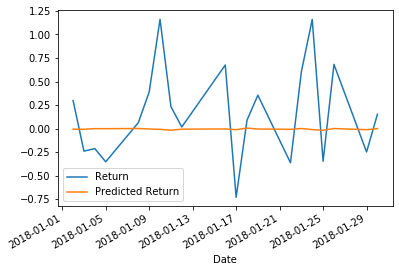

In [68]:
# Plot the first 20 predictions vs the true values
y_actual[:20].plot()

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [69]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(y_actual['Return'], y_actual['Predicted Return'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)

print(f'Out-of-Sample Root Mean Squared Error (RMSE): {rmse}')

Out-of-Sample Root Mean Squared Error (RMSE): 0.4138105378050125


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [70]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results['in_sample_predictions'] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(in_sample_results['Return'], in_sample_results['in_sample_predictions'])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)

print(f'In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}')

In-sample Root Mean Squared Error (RMSE): 0.5657562717010388


# Conclusions

YOUR CONCLUSIONS HERE!

RMSE gives us an indication how good the model is - lower value indicates better fit.
The model performs better on the Out-Of_Sample data (data that the model has not seen before aka testing data), opposed to In_Sample data (data that the model was trained on aka training data.